## Contents:
1. **Importing Dataset and Overview**
2. **Plotting CountPlots and Crosstabs for all features**
3. **Pre_Processing**
4. **Feature Engineering**
5. **Train and Test split**
6. **Feature Selection using Recursive Feature Elimination**
7. **Modelling**
8. **Hyperparameter tuning**
9. **Submission**

In [2]:
import math
import sklearn
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import pandas_profiling
import scipy.stats as ss
from sklearn import metrics
from sklearn.svm import SVC
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score 

Using TensorFlow backend.


### Importing Dataset and Overview

In [3]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
col_list = list(df.columns)
null_values = df.isnull().sum()    # Result: No missing values
idx_1 = np.where(df['Client Retention Flag'] == 'Yes') # Result : gives us the tuple of indices of m13=1
idx_0 = np.where(df['Client Retention Flag'] == "No")

1. idx cell is used to check if all retention values in dependent variables are not gathered at one place
2. No missing Values in our data labelled as NA
3. Since I use spyder, there is no need to write code for dataframe shape and all that...

In [4]:
ntrain = df.shape[0]
ntest = df_test.shape[0]
df['Client Retention Flag'].value_counts()
all_data = pd.concat([df, df_test], sort=False).reset_index(drop=True)
y = df['Client Retention Flag']
y.replace("Yes", 1, inplace = True)
y.replace("No", 0, inplace = True)
all_data.drop(['Client Retention Flag'], axis=1, inplace=True)

Compiling our train and test set, ntrain and ntest stores the number of rows in train and test set respectively

In [34]:
pandas_profiling.ProfileReport(df)

KeyboardInterrupt: 

This is something I came to know about recently, very useful for pre-processing saves a lot time. Since I got to know about it after pre-processing, following code may have repeated results.

In [5]:
numerical_features = df.select_dtypes(include=np.number)
categorical_features = df.select_dtypes(include=np.object)
print("numeric_features: ", numerical_features.shape, numerical_features.columns)
print("categorical_features: ", categorical_features.shape, categorical_features.columns)

numeric_features:  (8766, 101) Index(['Client ID', 'Company ID', 'Flag 2', 'Flag 5',
       'Activity 1 Time Period 11', 'Activity 1 Time Period 10',
       'Activity 1 Time Period 9', 'Activity 1 Time Period 8',
       'Activity 1 Time Period 7', 'Activity 1 Time Period 6',
       ...
       'Activity 8 Time Period 8', 'Activity 8 Time Period 7',
       'Activity 8 Time Period 6', 'Activity 8 Time Period 5',
       'Activity 8 Time Period 4', 'Activity 8 Time Period 3',
       'Activity 8 Time Period 2', 'Activity 8 Time Period 1',
       'Activity 8 Time Period 0', 'Client Retention Flag'],
      dtype='object', length=101)
categorical_features:  (8766, 5) Index(['Client Contract Starting Month', 'Flag 1', 'Flag 3', 'Flag 4',
       'Flag 6'],
      dtype='object')


Storing all numerical and categorical features in an array form for using them later in preprocessing

In [6]:
duplicated_companies = all_data[all_data.duplicated(['Company ID'], keep='first')]#There are companies with multiple clients

We will get to it while submitting this notebook

In [7]:
x = all_data.loc[all_data['Flag 4'] == 'No'] #this is done to check activity 5 have zero values for all months

This is just to check datapoints with Flag 4= No have zeroes in all time periods of corresponding activity

In [8]:
for i in range(2,105):
    print(col_list[i], '\n',all_data[col_list[i]].value_counts(normalize=True))

Client Contract Starting Month 
 Jun    0.146702
Mar    0.141511
Dec    0.123862
Sep    0.095432
Feb    0.076505
May    0.071714
Oct    0.071394
Jan    0.062211
Aug    0.060533
Apr    0.058377
Jul    0.050551
Nov    0.041207
Name: Client Contract Starting Month, dtype: float64
Flag 1 
 Single Year    0.680083
Multi Year     0.319917
Name: Flag 1, dtype: float64
Flag 2 
 2     0.499601
6     0.269685
7     0.138476
3     0.044322
10    0.033062
4     0.011979
13    0.001198
5     0.001038
1     0.000240
9     0.000160
12    0.000080
11    0.000080
8     0.000080
Name: Flag 2, dtype: float64
Flag 3 
 Yes    0.509264
No     0.490577
C      0.000160
Name: Flag 3, dtype: float64
Flag 4 
 Unknown    0.776633
Yes        0.222808
No         0.000559
Name: Flag 4, dtype: float64
Flag 5 
 8     0.298355
3     0.283741
15    0.210669
18    0.034899
7     0.030906
14    0.029468
6     0.024836
17    0.024517
19    0.011500
10    0.010222
16    0.010142
9     0.006069
12    0.005191
13    0.004153


Name: Activity 1 Time Period 5, Length: 190, dtype: float64
Activity 1 Time Period 4 
 0      0.354496
2      0.092318
4      0.065405
6      0.050870
1      0.040728
8      0.035537
10     0.030426
12     0.026433
3      0.023878
14     0.018767
16     0.017649
18     0.015333
5      0.014215
20     0.013656
24     0.012618
22     0.011260
28     0.008785
32     0.008465
7      0.008146
26     0.007906
9      0.007507
30     0.007427
11     0.006708
36     0.006708
34     0.006229
44     0.004792
42     0.004712
46     0.004472
40     0.004392
38     0.004153
         ...   
214    0.000080
246    0.000080
254    0.000080
470    0.000080
574    0.000080
590    0.000080
47     0.000080
111    0.000080
127    0.000080
628    0.000080
564    0.000080
388    0.000080
290    0.000080
129    0.000080
177    0.000080
193    0.000080
154    0.000080
210    0.000080
242    0.000080
250    0.000080
394    0.000080
276    0.000080
135    0.000080
123    0.000080
219    0.000080
172    0.000080
1

Activity 3 Time Period 10 
 0     0.895304
1     0.060294
2     0.024996
3     0.010621
4     0.004233
5     0.001837
7     0.001038
6     0.000799
11    0.000319
9     0.000240
8     0.000240
12    0.000080
Name: Activity 3 Time Period 10, dtype: float64
Activity 3 Time Period 9 
 0     0.893068
1     0.064686
2     0.022201
3     0.009264
4     0.005510
5     0.002236
6     0.001038
7     0.000799
9     0.000479
8     0.000479
19    0.000080
24    0.000080
16    0.000080
Name: Activity 3 Time Period 9, dtype: float64
Activity 3 Time Period 8 
 0     0.890593
1     0.062849
2     0.024357
3     0.010062
4     0.006389
5     0.003035
7     0.000878
6     0.000479
8     0.000399
12    0.000319
9     0.000160
20    0.000080
22    0.000080
11    0.000080
13    0.000080
10    0.000080
37    0.000080
Name: Activity 3 Time Period 8, dtype: float64
Activity 3 Time Period 7 
 0     0.885482
1     0.069398
2     0.024437
3     0.011819
4     0.004312
5     0.001517
6     0.001038
7     0.000719

Activity 8 Time Period 1 
 0    0.969094
1    0.027072
2    0.002635
3    0.000799
4    0.000240
5    0.000160
Name: Activity 8 Time Period 1, dtype: float64
Activity 8 Time Period 0 
 0    0.971251
1    0.024996
2    0.003274
3    0.000399
4    0.000080
Name: Activity 8 Time Period 0, dtype: float64


- Analysing value of count of whole dataframe

### Plotting CountPlots and Crosstabs for all features

In [ ]:
j=0
for i in col_list[2:105]:
    if j==6 or j==0:
        j=0
        fig, axs = plt.subplots(ncols=6)
    sns.countplot(df[i], ax = axs[j])
    j+=1

Yes    6170
No     2596
Name: Client Retention Flag, dtype: int64


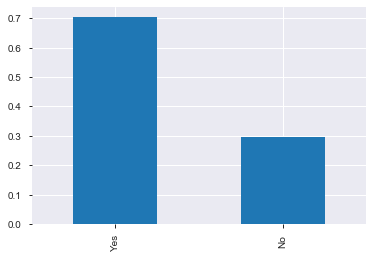

In [6]:
print(df['Client Retention Flag'].value_counts())
df['Client Retention Flag'].value_counts(normalize=True).plot.bar()

- We can get an idea of class imbalance from here

In [ ]:
for i in range(2,105):
    Flg3=pd.crosstab(df.iloc[:,i],df['Client Retention Flag'])
    Flg3.div(Flg3.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(40,40))
    #plt.rc('font', size=15) # controls default text sizes


Plotting Flag variables Seperately

In [ ]:
fig, axs = plt.subplots(ncols=3)
sns.countplot(x = 'Flag 1', data=df, ax = axs[0])
sns.countplot(x = 'Flag 2', data=df, ax = axs[1]) #this is an ordinal attribute 
sns.countplot(x = 'Flag 3', data=df, ax = axs[2])
axs[0].set(xlabel='Subsciption Age')
axs[1].set(xlabel='Service Category')
axs[2].set(xlabel='Eligibility for Inquiry')

fig, axs = plt.subplots(ncols=3)
sns.countplot(x = 'Client Contract Starting Month', data=df, ax = axs[0])
sns.countplot(x = 'Flag 5', data=df, ax = axs[1])
axs[1].set(xlabel='Region Category')
sns.countplot(x='Flag 6', data=df) #Industry of the clients

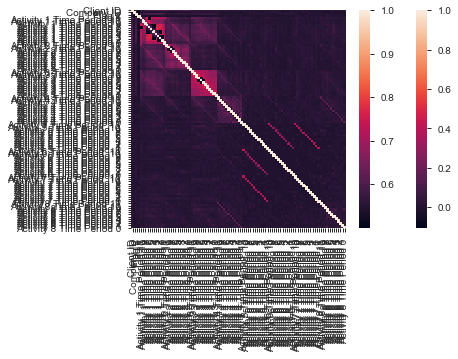

In [43]:
corr = all_data.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
pos_filtered_corr = corr[ corr.iloc[:,:] >= 0.5] # from this we easily know highly positively correlated values
neg_filtered_corr = corr[ corr.iloc[:,:] <= -0.5]
sns.heatmap(pos_filtered_corr,
            xticklabels=pos_filtered_corr.columns.values,
            yticklabels=pos_filtered_corr.columns.values)

1. No strong negative correlation is observed
2. though positive corrrelation is observed none of the variables is correlated more than 60 percent
3. None of the variable is correlated with Client retention variable strongly
4. Hence we conclude that no significant correlation exists between our features 

### Pre_Processing

In [9]:
def func(x):
    if (x==2):
        return 1
    elif (x==6):
        return 2
    elif (x==7):
        return 0
    else:
        return 3
def func2(x):
    if (x==3):
        return 1
    elif (x==8):
        return 2
    elif (x==15):
        return 0
    else:
        return 3
def func3(x):
    if (x=='Education'):
        return "Education"
    elif (x=='Manufacturing'):
        return "Manufacturing"
    elif (x=='Technology and Telecom'):
        return "Technology and Telecom"
    elif (x=="Government"):
        return "Government"
    else:
        return "Others"

- Reducing the number of levels in Categorical Features, you can see first function reduces into only three levels and function 2 into four levels and so on...

In [10]:
all_data['Flag 2_new'] = all_data['Flag 2'].apply(func)
all_data['Flag 5_new'] = all_data['Flag 5'].apply(func2)
all_data['Flag 6_new'] = all_data['Flag 6'].apply(func3)
print(all_data['Flag 6_new'].value_counts()) # just to check the changes have taken place or not

Education                 3553
Manufacturing             3040
Others                    2395
Technology and Telecom    2104
Government                1430
Name: Flag 6_new, dtype: int64


In [11]:
numerical_features_descript = numerical_features.iloc[:,:].describe()
Skewness_Kurtosis = pd.DataFrame({"Skewness": df.skew(), "Kurtosis": df.kurt()})

In [12]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(numerical_features.values, i) for i in range(numerical_features.shape[1])]
vif["features"] = numerical_features.columns

In [13]:
print(vif)

     VIF Factor                    features
0   -326.388603                   Client ID
1      1.033788                  Company ID
2      1.048476                      Flag 2
3      1.034712                      Flag 5
4      2.449855   Activity 1 Time Period 11
5      1.991695   Activity 1 Time Period 10
6      2.261210    Activity 1 Time Period 9
7      2.324283    Activity 1 Time Period 8
8      2.786217    Activity 1 Time Period 7
9      2.208037    Activity 1 Time Period 6
10     2.434652    Activity 1 Time Period 5
11     2.399039    Activity 1 Time Period 4
12     2.193633    Activity 1 Time Period 3
13     2.011145    Activity 1 Time Period 2
14     1.889371    Activity 1 Time Period 1
15     1.956639    Activity 1 Time Period 0
16     1.434117   Activity 2 Time Period 11
17     1.680834   Activity 2 Time Period 10
18     1.980759    Activity 2 Time Period 9
19     1.804508    Activity 2 Time Period 8
20     1.414180    Activity 2 Time Period 7
21     1.362462    Activity 2 Ti

- None of the variables shows significant value, thus we conclude that no multi collinearity is observed in our present set of features 

In [14]:
# Converting all binary categrical variables into numerical binary variables
all_data.replace("Yes", 1, inplace = True)
all_data.replace("No", 0, inplace = True)
all_data.replace("Single Year", 0, inplace = True)
all_data.replace("Multi Year", 1, inplace = True)
all_data.replace("C", 1, inplace = True)
all_data.drop(["Flag 6", "Flag 5", "Flag 2", "Flag 4"], axis=1, inplace=True)
all_data['Flag 5_new'] = all_data['Flag 5_new'].astype(str)
all_data['Flag 2_new'] = all_data['Flag 2_new'].astype(str)
all_data_colList = list(all_data.columns)
# From above analysis

In [15]:
for i in range(0,104):
    print(i, all_data_colList[i])

0 Client ID
1 Company ID
2 Client Contract Starting Month
3 Flag 1
4 Flag 3
5 Activity 1 Time Period 11
6 Activity 1 Time Period 10
7 Activity 1 Time Period 9
8 Activity 1 Time Period 8
9 Activity 1 Time Period 7
10 Activity 1 Time Period 6
11 Activity 1 Time Period 5
12 Activity 1 Time Period 4
13 Activity 1 Time Period 3
14 Activity 1 Time Period 2
15 Activity 1 Time Period 1
16 Activity 1 Time Period 0
17 Activity 2 Time Period 11
18 Activity 2 Time Period 10
19 Activity 2 Time Period 9
20 Activity 2 Time Period 8
21 Activity 2 Time Period 7
22 Activity 2 Time Period 6
23 Activity 2 Time Period 5
24 Activity 2 Time Period 4
25 Activity 2 Time Period 3
26 Activity 2 Time Period 2
27 Activity 2 Time Period 1
28 Activity 2 Time Period 0
29 Activity 3 Time Period 11
30 Activity 3 Time Period 10
31 Activity 3 Time Period 9
32 Activity 3 Time Period 8
33 Activity 3 Time Period 7
34 Activity 3 Time Period 6
35 Activity 3 Time Period 5
36 Activity 3 Time Period 4
37 Activity 3 Time Period 3

### Feature Engineering

In [16]:
all_data['activity_8_max'] = all_data[all_data_colList[89:100]].max(axis=1)
all_data['activity_7_max'] = all_data[all_data_colList[77:88]].max(axis=1)
all_data['activity_4_max'] = all_data[all_data_colList[42:53]].max(axis=1)
all_data['activity_5_max'] = all_data[all_data_colList[54:65]].max(axis=1) 
all_data['activity_3_max'] = all_data[all_data_colList[30:41]].max(axis=1)
all_data['activity_2_max'] = all_data[all_data_colList[18:29]].max(axis=1)
all_data['activity_1_max'] = all_data[all_data_colList[6:17]].max(axis=1)

In [52]:
print(all_data['activity_8_max']) #Just to check the results of above implementation

0        3
1        1
2        0
3        1
4        0
5        1
6        0
7        0
8        1
9        0
10       0
11       1
12       0
13       0
14       0
15       1
16       0
17       0
18       0
19       1
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
12492    0
12493    1
12494    0
12495    0
12496    0
12497    0
12498    0
12499    0
12500    1
12501    1
12502    0
12503    0
12504    0
12505    0
12506    0
12507    0
12508    0
12509    0
12510    0
12511    1
12512    1
12513    1
12514    0
12515    0
12516    0
12517    0
12518    0
12519    1
12520    0
12521    0
Name: activity_8_max, Length: 12522, dtype: int64


- Haven't included activity 6(binary), so it will just create a new column with same values as original column

In [17]:
all_data['activity_81'] = all_data['Activity 8 Time Period 6']+all_data['Activity 8 Time Period 10']+all_data['Activity 8 Time Period 5']+all_data['Activity 8 Time Period 4']+all_data['Activity 8 Time Period 1']
all_data['activity_82'] = all_data['Activity 8 Time Period 0']+all_data['Activity 8 Time Period 2']+ all_data['Activity 8 Time Period 3']+all_data['Activity 8 Time Period 7']+all_data['Activity 8 Time Period 8']+all_data['Activity 8 Time Period 9']
all_data['activity_71'] = all_data['Activity 7 Time Period  5']+all_data['Activity 7 Time Period  9']+all_data['Activity 7 Time Period  10']+all_data['Activity 7 Time Period  4']+all_data['Activity 7 Time Period  3']+all_data['Activity 7 Time Period  2']+all_data['Activity 7 Time Period  1']+all_data['Activity 7 Time Period  0'] #we can also use a for loop to make new column
all_data['activity_72'] = all_data['Activity 7 Time Period  7']+all_data['Activity 7 Time Period  8']+all_data['Activity 7 Time Period  6']
all_data['activity_62'] = all_data['Activity 6 Time Period  0']+all_data['Activity 6 Time Period  11']+all_data['Activity 6 Time Period  10']+all_data['Activity 6 Time Period  8']+all_data['Activity 6 Time Period  7']+all_data['Activity 6 Time Period  5']+all_data['Activity 6 Time Period  4']+all_data['Activity 6 Time Period  3']+all_data['Activity 6 Time Period  2']+all_data['Activity 6 Time Period  1']+all_data['Activity 6 Time Period  0']
all_data['activity_61'] = all_data['Activity 6 Time Period  6']+all_data['Activity 6 Time Period  9']+all_data['Activity 6 Time Period  1']
all_data['activity_51'] = all_data['Activity 5 Time Period  1']+all_data['Activity 5 Time Period  2']+all_data['Activity 5 Time Period  3']+all_data['Activity 5 Time Period  5']+all_data['Activity 5 Time Period  8']+all_data['Activity 5 Time Period  9']+all_data['Activity 5 Time Period  10']+all_data['Activity 5 Time Period  0']
all_data['activity_52'] = all_data['Activity 5 Time Period  4']+all_data['Activity 5 Time Period  6']+all_data['Activity 5 Time Period  7']+all_data['Activity 5 Time Period  11']
all_data['activity_41'] = all_data['Activity 4 Time Period 5']+all_data['Activity 4 Time Period 2']+all_data['Activity 4 Time Period 4']+all_data['Activity 4 Time Period 0']+all_data['Activity 4 Time Period 1']
all_data['activity_42'] = all_data['Activity 4 Time Period 6']+all_data['Activity 4 Time Period 7']+all_data['Activity 4 Time Period 9']+all_data['Activity 4 Time Period 11']+all_data['Activity 4 Time Period 10']

On the basis of careful observation on above plotted value counts and cross tabs, I have added certain columns to create new columns

In [18]:
Final_all_data_colList = list(all_data.columns)
print(Final_all_data_colList)

['Client ID', 'Company ID', 'Client Contract Starting Month', 'Flag 1', 'Flag 3', 'Activity 1 Time Period 11', 'Activity 1 Time Period 10', 'Activity 1 Time Period 9', 'Activity 1 Time Period 8', 'Activity 1 Time Period 7', 'Activity 1 Time Period 6', 'Activity 1 Time Period 5', 'Activity 1 Time Period 4', 'Activity 1 Time Period 3', 'Activity 1 Time Period 2', 'Activity 1 Time Period 1', 'Activity 1 Time Period 0', 'Activity 2 Time Period 11', 'Activity 2 Time Period 10', 'Activity 2 Time Period 9', 'Activity 2 Time Period 8', 'Activity 2 Time Period 7', 'Activity 2 Time Period 6', 'Activity 2 Time Period 5', 'Activity 2 Time Period 4', 'Activity 2 Time Period 3', 'Activity 2 Time Period 2', 'Activity 2 Time Period 1', 'Activity 2 Time Period 0', 'Activity 3 Time Period 11', 'Activity 3 Time Period 10', 'Activity 3 Time Period 9', 'Activity 3 Time Period 8', 'Activity 3 Time Period 7', 'Activity 3 Time Period 6', 'Activity 3 Time Period 5', 'Activity 3 Time Period 4', 'Activity 3 Time

In [19]:
for m in all_data_colList[77:100]:
    all_data[m] = all_data[m].apply(lambda x: 1 if (x > 0) else 0)
for m in all_data_colList[29:64]:
    all_data[m] = all_data[m].apply(lambda x: 1 if (x > 0) else 0)

- Reducing levels for numerical attributes since from count plot it can be observed that value of 0 is more than 95 percent in most activities.
- Note that we have excluded activity 1 and activity 2 while doing this
- This code will replace original columns

In [20]:
all_data.shape

(12522, 121)

### Train and Test split

In [21]:
Finalall_data = pd.get_dummies(all_data)
train = Finalall_data[:ntrain]
test = Finalall_data[ntrain:]

X = train.drop(["Client ID", "Company ID"], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### Feature Selection using Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE
nof_list=[30,15,27,24,18,21,40,50]         
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = xgb.XGBClassifier(random_state=0, n_jobs=-1, class_weight='balanced')
    rfe = RFE(model,nof_list[n], verbose=30)
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_test_rfe)
    score = f1_score(y_test, y_pred, average='weighted')
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))


- This piece of code gives us the optimum number of features obtained from nof_list we have given, and it also gives us the corresponding score from those chosen number of features.This same step is repeated with other algorithms like logistic Regression, Decision Tree Xlassifier,etc.

In [ ]:
from sklearn.feature_selection import RFE
nof_list=[30,15,27,24,18,21,40,50,60,70]         
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = LogisticRegression(random_state=0, class_weight='balanced')
    rfe = RFE(model,nof_list[n], verbose=30)
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_test_rfe)
    score = f1_score(y_test, y_pred, average='weighted')
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [ ]:
from sklearn.feature_selection import RFE
nof_list=[30,15,27,24,18,21,40,50]         
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = DecisionTreeClassifier(random_state=0, class_weight='balanced')
    rfe = RFE(model,nof_list[n], verbose=30)
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_test_rfe)
    score = f1_score(y_test, y_pred, average='weighted')
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [ ]:
from sklearn.feature_selection import RFE
nof_list=[30,15,27,24,18,21,40,50]         
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = GradientBoostingClassifier(random_state=0)
    rfe = RFE(model,nof_list[n], verbose=30)
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_test_rfe)
    score = f1_score(y_test, y_pred, average='weighted')
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
nof_list=[30,15,27,24,18,21,40,50]         
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = AdaBoostClassifier(random_state=0)
    rfe = RFE(model,nof_list[n], verbose=30)
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_test_rfe)
    score = f1_score(y_test, y_pred, average='weighted')
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [ ]:
nof_list=[30,15,27,24,18,21,40,50]         
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    model = RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=100)
    rfe = RFE(model,nof_list[n], verbose=30)
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_test_rfe)
    score = f1_score(y_test, y_pred, average='weighted')
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

In [ ]:
cols = list(X_train.columns)
model = GradientBoostingClassifier(random_state=0)
#Initializing RFE model
rfe = RFE(model, 15)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  
#Fitting the data to model
model.fit(X_rfe,y_train)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

- Here we are printing those optimal features which we have obtained from above feature recursive elimination, there we just got the number of optimal features here we are printing those features

In [ ]:
model = xgb.XGBClassifier(random_state=0, class_weight='balanced')
#Initializing RFE model
rfe = RFE(model, 18)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  
#Fitting the data to model
model.fit(X_rfe,y_train)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

In [ ]:
model = RandomForestClassifier(random_state=0, n_estimators=100)
#Initializing RFE model
rfe = RFE(model, 18)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X_train,y_train)  
#Fitting the data to model
model.fit(X_rfe,y_train)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

- After printing best features from three models(chose on the basis of scores they were giving on optimal number of selected features) through recursive elimination, we made a model_col_list containg list of top features

In [22]:
model_col_list = ['Activity 1 Time Period 11', 'Activity 1 Time Period 10',
       'Activity 1 Time Period 9', 'Activity 1 Time Period 8',
       'Activity 1 Time Period 7', 'Activity 1 Time Period 6',
       'Activity 1 Time Period 5', 'Activity 1 Time Period 4',
       'Activity 1 Time Period 3', 'Activity 1 Time Period 2',
       'Activity 1 Time Period 1', 'Activity 1 Time Period 0',
       'activity_3_max', 'activity_2_max', 'activity_1_max', 'activity_41',
       'activity_42', 'Client Contract Starting Month_Dec', 'Activity 2 Time Period 2',
        'Activity 3 Time Period 0', 'Flag 5_new_3', 'Activity 4 Time Period 0',
        'Flag 6_new_Government']

- model_col_list is the list of variables which are found to be most important from above feature elimination

### Modelling

In [23]:
train_sample = Finalall_data[:ntrain][model_col_list]
test_sample = Finalall_data[ntrain:][model_col_list]
train_sample = train_sample.iloc[:,:].values
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(train_sample, y, test_size=0.25, random_state=0)

- Splitting into train and test set(contains only those columns which are present in model_col_list

In [24]:
def Gartner_model(alg, X_train, y_train, X_test, y_test):
    model = alg
    model.fit(X_train, y_train) # training the model
#     prediction = model.predict_proba(xtest) # predicting on the validation set
#     prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
#     prediction_int = prediction_int.astype(np.int)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print(metrics.classification_report(y_test, y_pred, labels=[0,1]))
    print("f1_score train set:",f1_score(y_train, y_pred_train,average='weighted'))
    print("f1_score test set:",f1_score(y_test, y_pred,average='weighted')) # calculating f1 score

- Function to train and predict our data using different algoithm

In [70]:
algs = [DecisionTreeClassifier(random_state=0, class_weight='balanced'),
        RandomForestClassifier(random_state=0, class_weight='balanced'),
        ExtraTreesClassifier(random_state=0),AdaBoostClassifier(random_state=0),
        GradientBoostingClassifier(random_state=0),
        xgb.XGBClassifier(random_state=0, class_weight='balanced')]
algs_lst = ['DTC','RFC','ETC','ABC','GBC', 'XGB']
for alg,l in zip(algs,algs_lst):
    print(l)
    Gartner_model(alg,X_train_sample,y_train_sample,X_test_sample,y_test_sample)

DTC
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       643
           1       0.80      0.80      0.80      1549

    accuracy                           0.72      2192
   macro avg       0.66      0.66      0.66      2192
weighted avg       0.72      0.72      0.72      2192

f1_score train set: 0.9948401391779836
f1_score test set: 0.7167614053041792
RFC
              precision    recall  f1-score   support

           0       0.65      0.52      0.58       643
           1       0.82      0.89      0.85      1549

    accuracy                           0.78      2192
   macro avg       0.74      0.70      0.71      2192
weighted avg       0.77      0.78      0.77      2192

f1_score train set: 0.9875321339410856
f1_score test set: 0.7705335418279253
ETC
              precision    recall  f1-score   support

           0       0.58      0.49      0.53       643
           1       0.80      0.85      0.83      1549

    accuracy    

- This is a naive implementaion of models using different algorithms just to get idea of base scores that we are getting on our data

## Hyperparameter Tuning

In [30]:
def simple_model(alg, X_train, y_train, X_test, y_test):
    model = alg
#     prediction = model.predict_proba(xtest) # predicting on the validation set
#     prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
#     prediction_int = prediction_int.astype(np.int)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print(metrics.classification_report(y_test, y_pred, labels=[0,1]))
    print("f1_score train set:",f1_score(y_train, y_pred_train,average='weighted'))
    print("f1_score test set:",f1_score(y_test, y_pred,average='weighted'))

- Almost same as gartner_model function except we are using this function to make predictions from a already trained models

In [ ]:
#Defining the cross validation folds using stratifiedKFold
scv = StratifiedKFold(n_splits=5)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight='balanced', random_state=0)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                n_iter = 100, cv = scv, verbose=20, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_sample, y_train_sample)
rf_random.best_params_
rf_random.best_score_
simple_model(rf_random.best_estimator_,X_train_sample,y_train_sample,X_test_sample,y_test_sample)

In [35]:
# Created the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [30, 40, 50],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [6, 8, 10],
    'n_estimators': [2000, 2200, 2400]
}
#{'bootstrap': False,
# 'max_depth': 40,
# 'max_features': 'auto',
# 'min_samples_leaf': 1,
# 'min_samples_split': 8,
# 'n_estimators': 2000}
# Instantiated the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = scv, n_jobs = -1, verbose = 4)
grid_search.fit(X_train_sample, y_train_sample)
print(grid_search.best_params_)
print(grid_search.best_score_)
simple_model(grid_search.best_estimator_,X_train_sample,y_train_sample,X_test_sample,y_test_sample)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 26.3min finished


              precision    recall  f1-score   support

           0       0.73      0.52      0.61       643
           1       0.82      0.92      0.87      1549

    accuracy                           0.80      2192
   macro avg       0.78      0.72      0.74      2192
weighted avg       0.80      0.80      0.79      2192

f1_score train set: 0.989855654481879
f1_score test set: 0.7915312483350205


In [36]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'bootstrap': False, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 2000}
0.7806510495892911


In [32]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
            min_samples_split=500,
            min_samples_leaf=50,max_depth=8,max_features='sqrt',
            subsample=0.8,random_state=10),param_grid = param_test1,
            scoring='f1_weighted',n_jobs=-1,iid=False, cv=scv, verbose=5)
gsearch1.fit(X_train_sample, y_train_sample)
print(gsearch1.best_params_)
print(gsearch1.best_score_)
param_test2 = {'max_depth':range(1,33,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,
                       n_estimators=80, max_features='sqrt', subsample=0.8, random_state=10), 
                    param_grid = param_test2, scoring='f1_weighted',n_jobs=-1,iid=False,
                    cv=scv, verbose=10)
gsearch2.fit(X_train_sample, y_train_sample)
print(gsearch2.best_params_)
print(gsearch2.best_score_)    
param_test3 = {'min_samples_split':range(100,400,100), 'min_samples_leaf':range(1,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_depth=31,
                       n_estimators=80, max_features='sqrt', subsample=0.8, random_state=10), 
                    param_grid = param_test3, scoring='f1_weighted',n_jobs=-1,iid=False,
                    cv=scv, verbose=10)
gsearch3.fit(X_train_sample, y_train_sample)
print(gsearch3.best_params_)
print(gsearch3.best_score_)
param_test4 = {'max_features':range(15,24)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_depth=31,
                       n_estimators=80, min_samples_leaf=1,
                       min_samples_split=200, subsample=0.8, random_state=10), 
                    param_grid = param_test4, scoring='f1_weighted',n_jobs=-1,iid=False,
                    cv=scv, verbose=10)
gsearch4.fit(X_train_sample, y_train_sample)
print(gsearch4.best_params_)
print(gsearch4.best_score_)

param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_depth=31,
                       n_estimators=80, min_samples_leaf=1,
                       max_features=21,
                       min_samples_split=200, random_state=10), 
                    param_grid = param_test5, scoring='f1_weighted',n_jobs=-1,iid=False,
                    cv=scv, verbose=10)
gsearch5.fit(X_train_sample, y_train_sample)
print(gsearch5.best_params_)
print(gsearch5.best_score_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:    2.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    3.4s finished


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 101 out of 105 | elapsed:   22.9s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:   23.0s finished


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  35 out of  45 | elapsed:   28.1s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   29.8s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   34.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   34.4s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   17.6s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   19.3s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   23.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   24.7s finished


              precision    recall  f1-score   support

           0       0.85      0.68      0.76       643
           1       0.88      0.95      0.91      1549

    accuracy                           0.87      2192
   macro avg       0.86      0.82      0.83      2192
weighted avg       0.87      0.87      0.87      2192

f1_score train set: 0.9942205067066772
f1_score test set: 0.866792450775256


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   35.5s remaining:   53.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   35.6s remaining:   23.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.8s finished


0.009043589326256036

In [ ]:
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=160,
                            max_depth=31, min_samples_split=200,min_samples_leaf=1, 
                            subsample=0.9, random_state=10, max_features=21)
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500,
                            max_depth=31, min_samples_split=200,min_samples_leaf=1, 
                            subsample=0.9, random_state=10, max_features=21)

- I made gbm_tuned_2 as it was giving better results with it's parameters

In [33]:
Gartner_model(gbm_tuned_2,X_train_sample,y_train_sample,X_test_sample,y_test_sample)

crossvalscore = cross_val_score(estimator=gbm_tuned_2, X=X_train_sample, y=y_train_sample, cv=scv,
                                scoring = 'f1_weighted', n_jobs=-1, verbose=30)
print(crossvalscore.mean())
print(crossvalscore.std())

              precision    recall  f1-score   support

           0       0.85      0.68      0.76       643
           1       0.88      0.95      0.91      1549

    accuracy                           0.87      2192
   macro avg       0.86      0.82      0.83      2192
weighted avg       0.87      0.87      0.87      2192

f1_score train set: 0.9942205067066772
f1_score test set: 0.866792450775256


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   34.5s remaining:   51.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   34.5s remaining:   23.0s


0.8559176147042983
0.009043589326256036


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.9s finished


### Submission

In [ ]:
index = pd.DataFrame(test['Client ID'])
index.reset_index(drop=True, inplace=True)
test = test.drop(["Client ID", "Company ID"], axis=1)
y_test_preds = gbm_tuned_2.predict(test_sample)
#Preparing to write a CSV file
submission_format = pd.DataFrame(y_test_preds)
submission_format.columns = ['Client Retention Flag']
submission_format.replace(0, 'No',inplace=True) 
submission_format.replace(1, 'Yes',inplace=True)
FinalSubmission = pd.concat([index, submission_format], sort=False, axis=1)
FinalSubmission = FinalSubmission.sort_values(by='Client ID')
FinalSubmission.to_csv(r"C:\Users\Suraj\Google Drive\Ubuntu\ML Problems\Gartner Hackelite\FinalSubmission.csv",
                       header=True, index=None)